In [1]:
# библиотека для визуализации данных
import matplotlib.pyplot as plt

# библиотеки для работы с файлами
import os
import shutil

# модуль для разделения данных на несколько выборок
from sklearn.model_selection import train_test_split

import random
from PIL import Image, ImageDraw

Для реализации распознования объектов был собран датасет из фотографий конкурсных объектов. Фотографии были размечены с помощью инструмента Yolo Annotation Tool и сохранены в папке data. 

**Структура данных в наборе:**


└── data/    

        └── images/       # папка с фотографиями
            └── 001.jpg         # экземпляр фото
            └── 002.jpg
            └── 003.jpg
            └── etc ...
        └── labels/       # папка с разметкой 
            └── 001.txt         # экземляр разметки в формате YOLO (txt файл)
            └── 002.txt
            └── 003.txt
            └── etc ...
        


Для начала проверим баланс классов в датасете. Проверка баланса классов важна, чтобы убедиться, что модель не будет смещена в сторону определенных фигур. Если одной из фигур значительно больше чем других, то это может повлиять на качество распознавания.

In [2]:
labels_path = r"C:\Users\Илья\Documents\GitHub\robost_prep_1\data\labels"
images_path = r"C:\Users\Илья\Documents\GitHub\robost_prep_1\data\images"

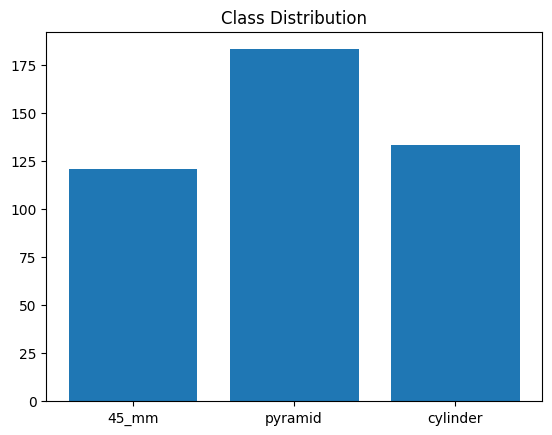

In [3]:
# создаю словарь для подсчета количества экземпляров разметки для каждого класса
class_counts = {}
# перебираю все txt-файлы с разметкой в формате yolo
for label_file in os.listdir(labels_path):
    with open(f"{labels_path}/{label_file}") as f:
        for line in f:
          # из каждого файла беру айди класса разметки и обновляю счетчики
            class_id = int(line.split()[0])
            class_counts[class_id] = class_counts.get(class_id, 0) + 1


# вывожу график баланса классов
plt.bar(["45_mm", "pyramid", "cylinder"], class_counts.values())
plt.title("Class Distribution")
plt.show()

In [4]:
print(f"Общее кол-во объектов: {sum(class_counts.values())}")

Общее кол-во объектов: 437


Визуальная проверка насколько правильно размечены фотографии на основе случайной фотки??


In [5]:
img_files = os.listdir(images_path)
random_img = random.choice(img_files)

img = Image.open(fr"{images_path}/{random_img}")
draw = ImageDraw.Draw(img)

with open(fr"{labels_path}/{random_img.replace('.jpg', '.txt')}") as f:
    for line in f:
        class_id, x_center, y_center, w, h = map(float, line.split())
        
        # Конвертация YOLO формата в пиксельные координаты
        W, H = img.size
        x1 = (x_center - w/2) * W
        y1 = (y_center - h/2) * H
        x2 = (x_center + w/2) * W
        y2 = (y_center + h/2) * H
        
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

img.show()

Text(0, 0.5, 'Height (normalized)')

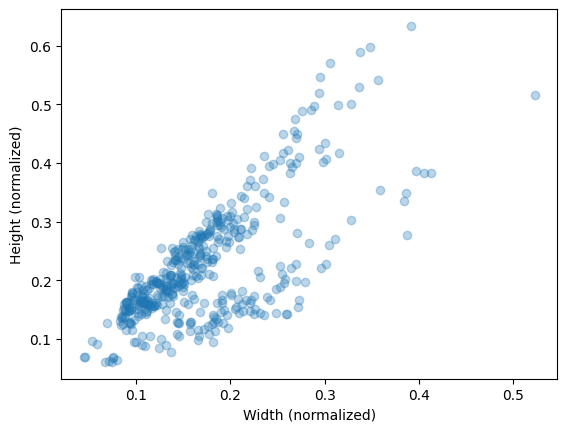

In [48]:
# Размеры боксов

widths, heights = [], []
for label_file in os.listdir(labels_path):
    with open(f"{labels_path}/{label_file}") as f:
        for line in f:
            _, _, _, w, h = map(float, line.split())
            widths.append(w)
            heights.append(h)

plt.scatter(widths, heights, alpha=0.3)
plt.xlabel("Width (normalized)")
plt.ylabel("Height (normalized)")

In [49]:
for i in widths:
  print(i)

0.16630622837370243
0.20761245674740483
0.18901384083044984
0.19117647058823528
0.15513264129181084
0.2315455594002307
0.18281430219146483
0.14359861591695502
0.17243367935409457
0.18598615916955016
0.1513840830449827
0.1379757785467128
0.14381487889273356
0.10423875432525952
0.09803921568627451
0.13948961937716264
0.12716262975778547
0.20098039215686275
0.12399077277970011
0.13667820069204153
0.08628892733564014
0.10034602076124567
0.0921280276816609
0.14057093425605535
0.09320934256055363
0.14121972318339102
0.10532006920415225
0.13105536332179932
0.11548442906574395
0.14078719723183392
0.15960207612456748
0.13646193771626297
0.13927335640138408
0.1518166089965398
0.092560553633218
0.12802768166089964
0.12889273356401384
0.08866782006920415
0.18901384083044984
0.10553633217993079
0.10056228373702422
0.092560553633218
0.11094290657439447
0.10575259515570934
0.14381487889273356
0.13386678200692043
0.10813148788927336
0.09775086505190311
0.08910034602076125
0.09191176470588236
0.1111591

Вычисление соотношения сторон объектов, поможет выбрать anchor boxes для YOLO

Text(0.5, 1.0, 'Aspect Ratio Distribution')

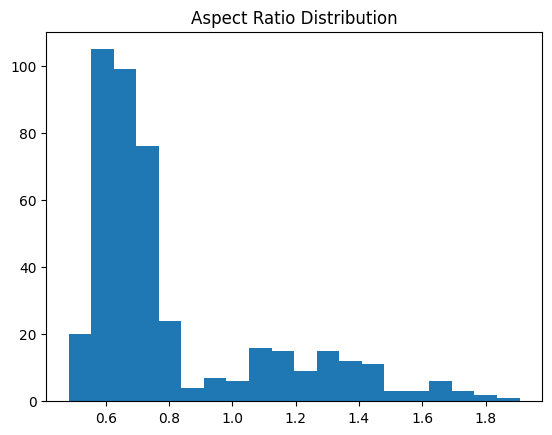

In [50]:
aspect_ratios = [w/h for w,h in zip(widths, heights)]
plt.hist(aspect_ratios, bins=20)
plt.title("Aspect Ratio Distribution")

Если обнаружен дисбаланс классов - добавить аугментации для редких классов

При большом разбросе размеров объектов - добавить multi-scale обучение

Если объекты смещены к центру - добавить случайные кадрирования

При низком разрешении изображений - использовать super-resolution

Если обнаружены ошибки разметки - провести ревизию датасета

- добавить аугментации,
- добавить мультискейл?
- посоветоваться с Надей
- изменить структуру папок
- обучить модель

In [51]:
# путь для выходных изображений и разметок
out_dir = r'C:\Users\Илья\Documents\GitHub\robost_prep_1\Module_4\data'

# создаем выходные пути для train, test И valid
# для тренировочного набора
os.makedirs(os.path.join(out_dir, 'train/images'), exist_ok=True) # картинки
os.makedirs(os.path.join(out_dir, 'train/labels'), exist_ok=True) # разметка
# для тестового набора
os.makedirs(os.path.join(out_dir, 'test/images'), exist_ok=True) # картинки
os.makedirs(os.path.join(out_dir, 'test/labels'), exist_ok=True) # разметка
# для валидационного набора
os.makedirs(os.path.join(out_dir, 'valid/images'), exist_ok=True) # картинки
os.makedirs(os.path.join(out_dir, 'valid/labels'), exist_ok=True) # разметка

In [52]:
# получаем список всех изображений
images = os.listdir(images_path)
# логирование
print(len(images),'- колво фотографий')

266 - колво фотографий


In [53]:
# разделяем датасет на 3 выборки: 70% train, 15% valid и 15% test
train_img, test_img = train_test_split(images, test_size=0.3, random_state=42)
val_img, test_img = train_test_split(test_img, test_size=0.5, random_state=42)
# где images и test_img - выборка которую мы разделяем, test_size - процент, который будет составлять тестовая выборка при разделении
# random_state - сид, для воспроизводимости

print(len(train_img), 'train len')
print(len(test_img), 'test len')
print(len(val_img), 'valid len')

186 train len
40 test len
40 valid len


*реализуем функцию, для копирования фотографий и их разметок в нужные папки*

In [54]:
# функция для копирования файлов
def files_copy(files, img, labels, out_img, out_labels):
    # проходимся по каждой фотке из выборок
    for file in files:
        # копируем фотографии
        shutil.copy(os.path.join(img, file), os.path.join(out_img, file))
        # копируем разметку
        # инициализируем название разметки
        label_file = os.path.splitext(file)[0] + '.txt'
        # копируем файл с разметкой в нужную папку
        shutil.copy(os.path.join(labels, label_file), os.path.join(out_labels, label_file))
    
    # логирование
    print(len(os.listdir(out_img)), '- размер папки с изображениями')
    print(len(os.listdir(out_labels)), '- размер папки с разметками')
    print('----------------------------------------------')

После того как мы реализовали функцию, можно начать раскидывать файлы по папкам

In [55]:
# копируем тренировочную выборку
files_copy(train_img, images_path, labels_path, os.path.join(out_dir, 'train/images'), os.path.join(out_dir, 'train/labels'))
# копируем тестовую выборку
files_copy(test_img, images_path, labels_path, os.path.join(out_dir, 'test/images'), os.path.join(out_dir, 'test/labels'))
# копируем валидационную выборку
files_copy(val_img, images_path, labels_path, os.path.join(out_dir, 'valid/images'), os.path.join(out_dir, 'valid/labels'))

192 - размер папки с изображениями
191 - размер папки с разметками
----------------------------------------------
40 - размер папки с изображениями
40 - размер папки с разметками
----------------------------------------------
40 - размер папки с изображениями
40 - размер папки с разметками
----------------------------------------------
